## Inference Pipeline

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from scripts.joint_regressor import JointRegressor
from scripts.checkpoint_utils import load_full_checkpoint
from scripts.dlrhand2_joint_datamodule import _sample_mesh_as_pc


def load_model(
    joint_ckpt: str,
    config_path: str,
    backbone_ckpt: str | None = None,
    device: str = "cuda:0"
) -> JointRegressor:
    """Instantiate JointRegressor, optionally load a JEPA backbone, then load trained joint-ckpt weights."""
    # Load training config
    cfg = OmegaConf.load(config_path)

    # Build model with training hyperparams
    model = JointRegressor(
        num_points             = cfg.data.num_points,
        tokenizer_groups       = cfg.model.tokenizer_groups,
        tokenizer_group_size   = cfg.model.tokenizer_group_size,
        tokenizer_radius       = cfg.model.tokenizer_radius,
        transformations        = cfg.model.transformations,
        coord_change           = cfg.model.coord_change,
        encoder_dim            = cfg.model.encoder_dim,
        encoder_depth          = cfg.model.encoder_depth,
        encoder_heads          = cfg.model.encoder_heads,
        encoder_dropout        = cfg.model.encoder_dropout,
        encoder_attn_dropout   = cfg.model.encoder_attn_dropout,
        encoder_drop_path_rate = cfg.model.encoder_drop_path_rate,
        encoder_mlp_ratio      = cfg.model.encoder_mlp_ratio,
        pooling_type           = cfg.model.pooling_type,
        pooling_heads          = cfg.model.pooling_heads,
        pooling_dropout        = 0.1,
        head_hidden_dims       = cfg.model.head_hidden_dims,
        head_dropout           = cfg.model.head_dropout,  # ← NEW
        pose_dim               = 7,
        lr_backbone            = cfg.model.lr_backbone,
        lr_head                = cfg.model.lr_head,
        weight_decay           = cfg.model.weight_decay,
        encoder_unfreeze_epoch = cfg.model.encoder_unfreeze_epoch,
        encoder_unfreeze_step  = cfg.model.encoder_unfreeze_step,
        num_pred               = cfg.model.num_pred,
        loss_type              = cfg.model.loss_type,
        logit_scale_init       = cfg.model.logit_scale_init,
        logit_scale_min        = cfg.model.logit_scale_min,
        logit_scale_max        = cfg.model.logit_scale_max,
    )

    # Load backbone pretrain if provided
    if backbone_ckpt:
        load_full_checkpoint(model, backbone_ckpt)

    # Load full joint-regression checkpoint (overwrites head + backbone)
    checkpoint = torch.load(joint_ckpt, map_location=device)
    state = checkpoint.get('state_dict', checkpoint)
    model.load_state_dict(state, strict=False)

    model.eval()
    model.freeze()
    model.to(device)
    return model


@torch.inference_mode()
def predict_joint_angles(
    model: JointRegressor,
    mesh_path: str,
    pose7d: list[float] | np.ndarray,
    num_points: int | None = None,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Given a mesh file and a 7D hand pose, returns the 12-D joint-angle prediction.
    """
    n_pts = num_points or model.hparams.num_points
    pc = _sample_mesh_as_pc(mesh_path, n=n_pts)

    pts = torch.from_numpy(pc).unsqueeze(0).to(device)
    pose = torch.as_tensor(pose7d, dtype=torch.float32).unsqueeze(0).to(device)

    if model.loss_type == "basic":
        pred_angles = model(pts, pose)
        return pred_angles
    elif model.loss_type == "min_k":
        pred_angles = model(pts, pose)
        return pred_angles
    elif model.loss_type == "min_k_logit":
        pred_angles, pred_logit = model(pts, pose)  # (B, num_pred, 12), (B,num_pred), (B,num_pred)
        pred_angles = pred_angles.squeeze(0).cpu().numpy() # (num_pred, 12)
        pred_logit = pred_logit.squeeze(0).cpu().numpy()   # (num_pred,)
        return pred_angles, pred_logit
    elif model.loss_type == "full":
        pred_angles, pred_logit, pred_score = model(pts, pose)
        pred_angles = pred_angles.squeeze(0).cpu().numpy() # (num_pred, 12)
        pred_logit = pred_logit.squeeze(0).cpu().numpy()   # (num_pred,)
        pred_score = pred_score.squeeze(0).cpu().numpy()   # (num_pred,)
        return pred_angles, pred_logit, pred_score
    else:
        raise ValueError(f"Unknown loss type '{model.loss_type}'. Available types: "
                        f"basic, min_k, attention, min_k_logit, full")

# Example usage:
# model = load_model(
#     joint_ckpt="checkpoints/joint-final.ckpt",
#     config_path="configs/train_joint.yaml",
#     backbone_ckpt="checkpoints/pretrain-pointjepa.ckpt",  # optional
#     device="cuda:0"
# )
# angles = predict_joint_angles(model, mesh_path, hand_pose)
# print(angles)


/home/jguzeel_gmail_com/jed-repo/ADLR/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prediction Visualization

Using DIRECT mode, client ID: 2

MLP Head Architecture (loss_type: min_k_logit)
Input dimension: 391
Hidden dimensions: [512, 256, 128]
Output dimension: 65

Layer-by-layer breakdown:
--------------------------------------------------

 Closest to ground truth prediction: 
 [ 0.03143 -0.0934   0.341   -0.2048  -0.03485  0.3418  -0.359   -0.04285
  0.3147  -0.2898  -0.1952   0.2534 ]

 Inference time prediction: 
 [ 0.1935 -0.1951  0.4973  0.0505 -0.137   0.4338 -0.15   -0.2057  0.4153
 -0.3345 -0.1752  0.2162]

 Logits: 
 [-0.03378 -0.309   -1.358    0.132    0.4426 ]
Grasp 0:
    palm  (xyz, qxqyqzqw) = [-0.028, -0.004, 0.293, 0.009, 0.986, -0.011, 0.167]
    joints (12 angles)  = [[0.384033203125, 1.4716796875, 1.802734375, 0.18505859375, -0.0999755859375, 0.318115234375, -0.114013671875, -0.135009765625, 0.361083984375, -0.241943359375, -0.2430419921875, 0.22705078125], [0.1510009765625, 0.1610107421875, 0.2130126953125, -0.031005859375, 0.300048828125, 0.1700439453125, -0.271972656

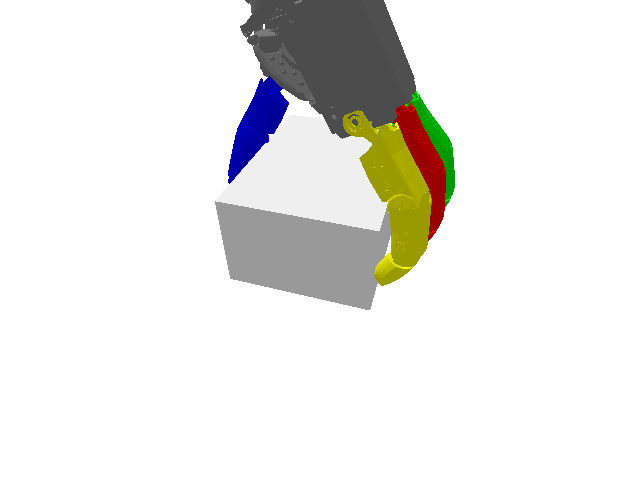


 Closest to ground truth prediction: 
 [-0.02026 -0.03204  0.2583  -0.2866   0.03833  0.2393  -0.4282   0.02
  0.2286  -0.2595  -0.09406  0.253  ]

 Inference time prediction: 
 [ 0.1797  -0.2157   0.427   -0.00613 -0.0742   0.4465  -0.2496  -0.1317
  0.426   -0.315   -0.0738   0.2316 ]

 Logits: 
 [-0.3584  -0.03455 -1.457    0.3167   0.3945 ]
Grasp 1:
    palm  (xyz, qxqyqzqw) = [-0.045, -0.011, 0.296, -0.012, 0.986, 0.016, 0.166]
    joints (12 angles)  = [[0.384033203125, 1.4677734375, 1.80078125, 0.2010498046875, -0.1240234375, 0.1619873046875, -0.1650390625, -0.10601806640625, 0.318115234375, -0.22802734375, -0.1639404296875, 0.2149658203125], [0.1610107421875, 0.220947265625, 0.1409912109375, -0.07098388671875, 0.35595703125, 0.0980224609375, -0.3330078125, 0.3759765625, 0.114990234375, -0.327880859375, -0.1419677734375, 0.2330322265625], [0.39501953125, 0.403076171875, 0.72216796875, 0.27392578125, -0.0419921875, 0.406982421875, -0.072998046875, -0.11602783203125, 0.4299316406

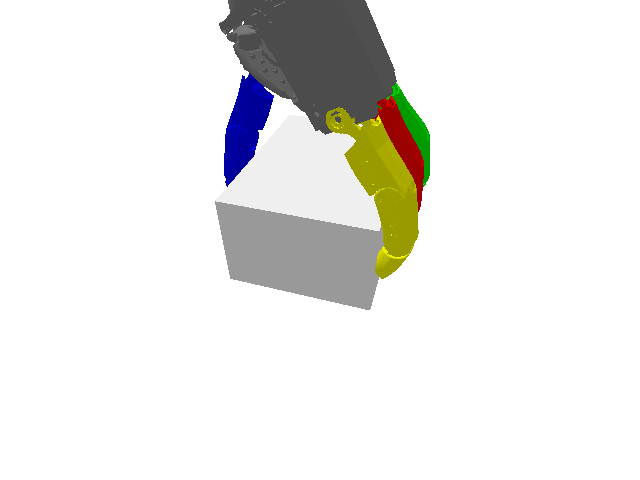


 Closest to ground truth prediction: 
 [ 0.02199 -0.04175  0.3052  -0.2505   0.03244  0.2908  -0.4087   0.02051
  0.2725  -0.2942  -0.211    0.267  ]

 Inference time prediction: 
 [ 0.1715 -0.2292  0.4473  0.0154 -0.1161  0.4626 -0.2195 -0.165   0.4421
 -0.3396 -0.1575  0.2194]

 Logits: 
 [-0.296  -0.3098 -1.217   0.1225  0.6157]
Grasp 2:
    palm  (xyz, qxqyqzqw) = [-0.053, 0.005, 0.291, -0.021, 0.976, 0.016, 0.217]
    joints (12 angles)  = [[0.383056640625, 1.4775390625, 1.810546875, 0.2020263671875, -0.1800537109375, 0.22705078125, -0.1529541015625, -0.155029296875, 0.39111328125, -0.26806640625, -0.22705078125, 0.2320556640625], [0.1810302734375, 0.18798828125, 0.196044921875, -0.0369873046875, 0.340087890625, 0.1519775390625, -0.306884765625, 0.4150390625, 0.1639404296875, -0.337890625, -0.1800537109375, 0.2139892578125], [0.384033203125, 0.4140625, 0.7998046875, 0.27001953125, -0.1199951171875, 0.471923828125, -0.048004150390625, -0.1929931640625, 0.491943359375, -0.342041015

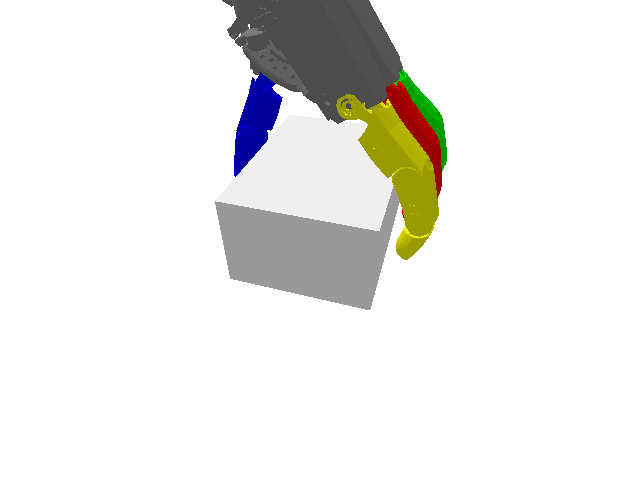


 Closest to ground truth prediction: 
 [ 0.393    1.493    1.835    0.1964  -0.1387   0.2546  -0.1276  -0.11084
  0.3591  -0.256   -0.23     0.218  ]

 Inference time prediction: 
 [ 0.1956  -0.2233   0.4834   0.03558 -0.1295   0.4524  -0.1819  -0.2024
  0.4302  -0.331   -0.1444   0.207  ]

 Logits: 
 [-0.11206 -0.1715  -1.536    0.1547   0.5117 ]
Grasp 3:
    palm  (xyz, qxqyqzqw) = [-0.043, 0.054, 0.288, 0.668, 0.714, -0.069, 0.199]
    joints (12 angles)  = [[0.39306640625, 1.4931640625, 1.8349609375, 0.196044921875, -0.1390380859375, 0.2548828125, -0.1280517578125, -0.11102294921875, 0.35888671875, -0.256103515625, -0.22998046875, 0.218017578125], [0.1729736328125, 0.1910400390625, 0.197998046875, -0.0279998779296875, 0.346923828125, 0.14404296875, -0.285888671875, 0.4130859375, 0.154052734375, -0.344970703125, -0.1839599609375, 0.199951171875], [0.39306640625, 0.759765625, 1.1552734375, 0.256103515625, -0.135986328125, 0.43994140625, -0.07598876953125, -0.2080078125, 0.4460449218

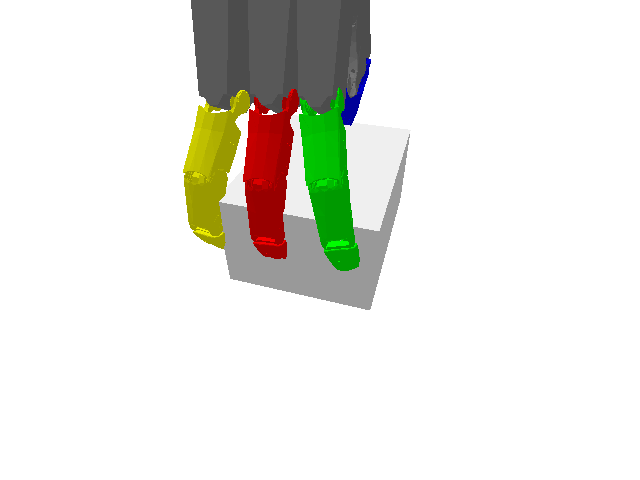


 Closest to ground truth prediction: 
 [ 0.3984   1.492    1.839    0.1932  -0.1293   0.1595  -0.1644  -0.10944
  0.2683  -0.1927  -0.1343   0.2151 ]

 Inference time prediction: 
 [-2.577e-02 -6.830e-02  2.632e-01 -2.891e-01 -7.039e-05  2.423e-01
 -4.192e-01 -8.568e-03  2.278e-01 -2.549e-01 -6.769e-02  2.424e-01]

 Logits: 
 [-0.1718  0.0667 -1.906   0.4841  0.321 ]
Grasp 4:
    palm  (xyz, qxqyqzqw) = [-0.052, 0.006, 0.304, 0.701, 0.702, -0.004, 0.125]
    joints (12 angles)  = [[0.39794921875, 1.4921875, 1.8388671875, 0.1929931640625, -0.1290283203125, 0.1600341796875, -0.1639404296875, -0.1090087890625, 0.26806640625, -0.1929931640625, -0.134033203125, 0.2149658203125], [0.1400146484375, 0.2110595703125, 0.114990234375, -0.094970703125, 0.340087890625, 0.061004638671875, -0.35693359375, 0.3349609375, 0.08197021484375, -0.319091796875, -0.1209716796875, 0.2349853515625], [0.407958984375, 0.67822265625, 1.05078125, 0.26708984375, -0.093994140625, 0.3740234375, -0.11700439453125, -0.

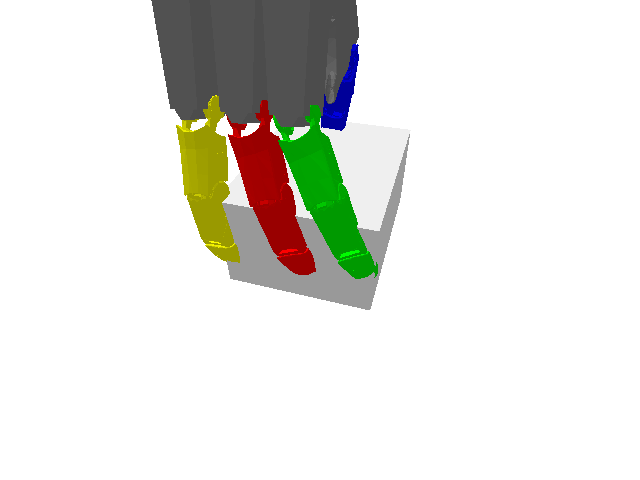


 Closest to ground truth prediction: 
 [ 0.1893   -0.2328    0.4678    0.013275 -0.1005    0.4556   -0.2076
 -0.1636    0.4307   -0.322    -0.0839    0.2147  ]

 Inference time prediction: 
 [ 0.1893   -0.2328    0.4678    0.013275 -0.1005    0.4556   -0.2076
 -0.1636    0.4307   -0.322    -0.0839    0.2147  ]

 Logits: 
 [-0.0948   0.05017 -1.722    0.1674   0.3467 ]
Grasp 5:
    palm  (xyz, qxqyqzqw) = [-0.014, 0.046, 0.302, 0.709, 0.678, -0.1, 0.167]
    joints (12 angles)  = [[0.39404296875, 1.5078125, 1.8603515625, 0.1949462890625, -0.1240234375, 0.1590576171875, -0.137939453125, -0.08599853515625, 0.330078125, -0.248046875, -0.1729736328125, 0.2049560546875], [0.1600341796875, 0.2039794921875, 0.18994140625, -0.042999267578125, 0.345947265625, 0.135009765625, -0.2939453125, 0.382080078125, 0.157958984375, -0.360107421875, -0.176025390625, 0.2159423828125], [0.39599609375, 0.6708984375, 1.009765625, 0.256103515625, -0.08001708984375, 0.424072265625, -0.094970703125, -0.1529541015

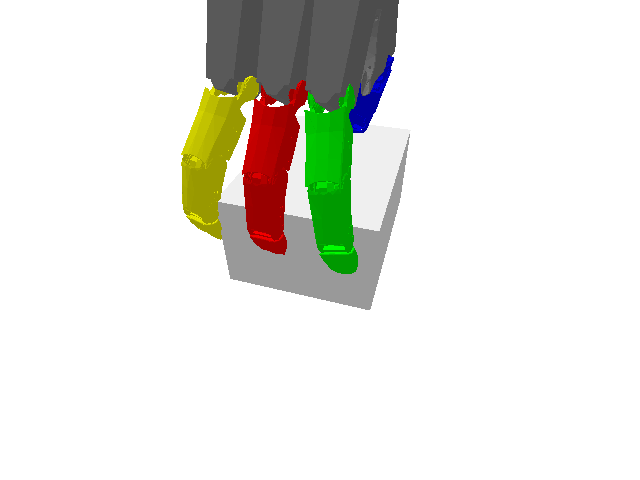


 Closest to ground truth prediction: 
 [ 0.1427  0.1388  0.1865 -0.0805  0.3137  0.1304 -0.365   0.4207  0.1621
 -0.3472 -0.1713  0.2415]

 Inference time prediction: 
 [ 0.1599  -0.2637   0.4482  -0.00875 -0.1421   0.4395  -0.2472  -0.2153
  0.4185  -0.3535  -0.153    0.2257 ]

 Logits: 
 [ 0.02643 -0.388   -1.713    0.3572   0.6323 ]
Grasp 6:
    palm  (xyz, qxqyqzqw) = [-0.038, 0.029, 0.29, 0.997, 0.029, -0.02, 0.074]
    joints (12 angles)  = [[0.39990234375, 1.564453125, 1.9248046875, 0.18994140625, -0.282958984375, 0.2030029296875, -0.1829833984375, -0.2548828125, 0.407958984375, -0.241943359375, -0.239990234375, 0.27294921875], [0.1429443359375, 0.1390380859375, 0.18603515625, -0.08001708984375, 0.31396484375, 0.1300048828125, -0.364990234375, 0.4208984375, 0.1619873046875, -0.346923828125, -0.1710205078125, 0.241943359375], [0.419921875, 0.451904296875, 0.92822265625, 0.302001953125, -0.1949462890625, 0.47509765625, -0.08502197265625, -0.2359619140625, 0.4619140625, -0.3510742

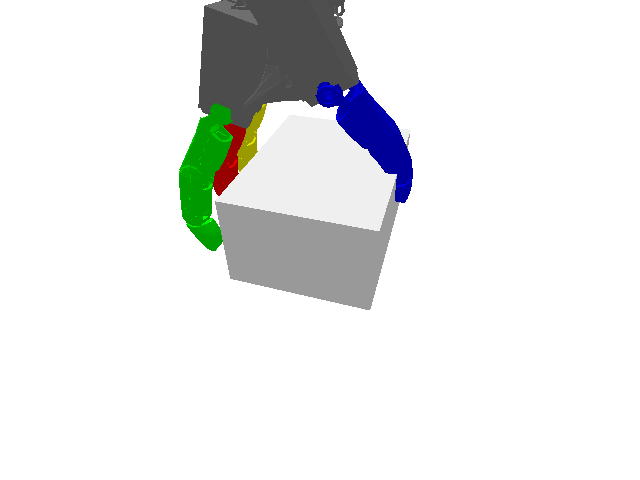


 Closest to ground truth prediction: 
 [ 0.17      0.1519    0.2482   -0.012085  0.3215    0.2025   -0.2686
  0.4763    0.2161   -0.358    -0.2173    0.18    ]

 Inference time prediction: 
 [ 0.1863  -0.2402   0.5      0.04968 -0.176    0.4653  -0.1597  -0.2188
  0.4453  -0.3474  -0.2174   0.1925 ]

 Logits: 
 [ 0.0465  -0.4006  -1.342   -0.08417  0.668  ]
Grasp 7:
    palm  (xyz, qxqyqzqw) = [0.02, 0.07, 0.297, 0.98, 0.019, -0.157, 0.12]
    joints (12 angles)  = [[0.383056640625, 1.5185546875, 1.8662109375, 0.18896484375, -0.1929931640625, 0.302001953125, -0.1240234375, -0.1800537109375, 0.431884765625, -0.280029296875, -0.27099609375, 0.2440185546875], [0.1700439453125, 0.1519775390625, 0.248046875, -0.01200103759765625, 0.322021484375, 0.2020263671875, -0.26806640625, 0.47607421875, 0.2159423828125, -0.35791015625, -0.217041015625, 0.1800537109375], [0.389892578125, 0.65087890625, 1.103515625, 0.260009765625, -0.1839599609375, 0.49609375, -0.05999755859375, -0.2430419921875, 0.50

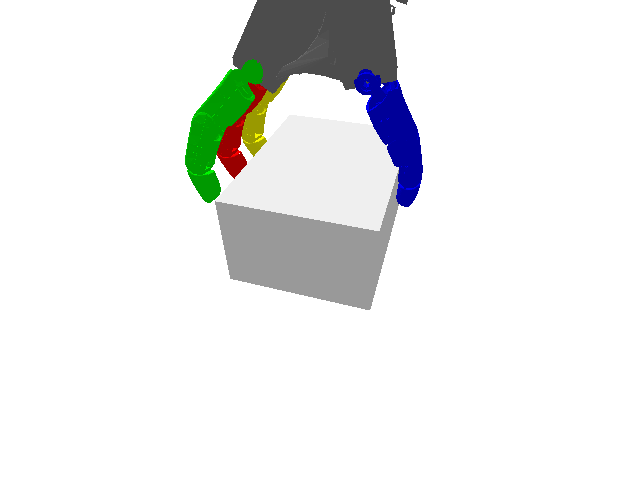


 Closest to ground truth prediction: 
 [ 0.04257 -0.0465   0.3208  -0.205    0.02281  0.3262  -0.3606   0.02748
  0.298   -0.3145  -0.2556   0.2354 ]

 Inference time prediction: 
 [ 0.1757  -0.2224   0.4856   0.04108 -0.155    0.4548  -0.1597  -0.1935
  0.4385  -0.3313  -0.2058   0.1976 ]

 Logits: 
 [ 0.007904 -0.3584   -1.287     0.02486   0.638   ]
Grasp 8:
    palm  (xyz, qxqyqzqw) = [0.037, 0.081, 0.295, 0.965, 0.04, -0.173, 0.194]
    joints (12 angles)  = [[0.3740234375, 1.4580078125, 1.7822265625, 0.178955078125, -0.14599609375, 0.306884765625, -0.1090087890625, -0.14404296875, 0.389892578125, -0.259033203125, -0.26904296875, 0.22900390625], [0.1639404296875, 0.177001953125, 0.2149658203125, -0.0189971923828125, 0.342041015625, 0.1729736328125, -0.262939453125, 0.47412109375, 0.1800537109375, -0.339111328125, -0.1949462890625, 0.175048828125], [0.3740234375, 0.68994140625, 1.0966796875, 0.2490234375, -0.14794921875, 0.455078125, -0.053009033203125, -0.2099609375, 0.4641113281

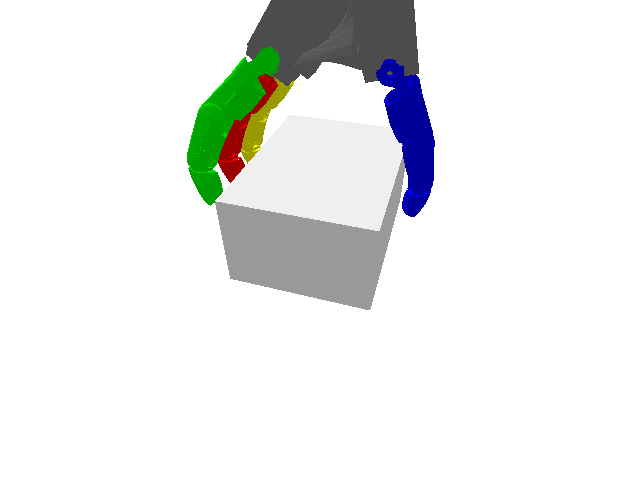


 Closest to ground truth prediction: 
 [ 0.06128 -0.00498  0.332   -0.1426   0.03384  0.3354  -0.299    0.01542
  0.3196  -0.3284  -0.2065   0.2212 ]

 Inference time prediction: 
 [ 0.06128 -0.00498  0.332   -0.1426   0.03384  0.3354  -0.299    0.01542
  0.3196  -0.3284  -0.2065   0.2212 ]

 Logits: 
 [-1.128    0.0167  -0.7285   0.2095  -0.04492]
Grasp 9:
    palm  (xyz, qxqyqzqw) = [0.053, 0.024, 0.287, 0.974, 0.024, -0.225, 0.027]
    joints (12 angles)  = [[0.39208984375, 1.4453125, 1.76953125, 0.2039794921875, 0.27490234375, 0.56494140625, -0.06402587890625, 0.035003662109375, 0.27197265625, -0.2459716796875, -0.2939453125, 0.2249755859375], [0.156005859375, 0.260009765625, 0.1810302734375, -0.009002685546875, 0.347900390625, 0.1610107421875, -0.2010498046875, 0.3701171875, 0.2049560546875, -0.345947265625, -0.261962890625, 0.20703125], [0.373046875, 1.1533203125, 1.5185546875, 0.1810302734375, -0.07501220703125, 0.385009765625, -0.09197998046875, -0.1600341796875, 0.40307617187

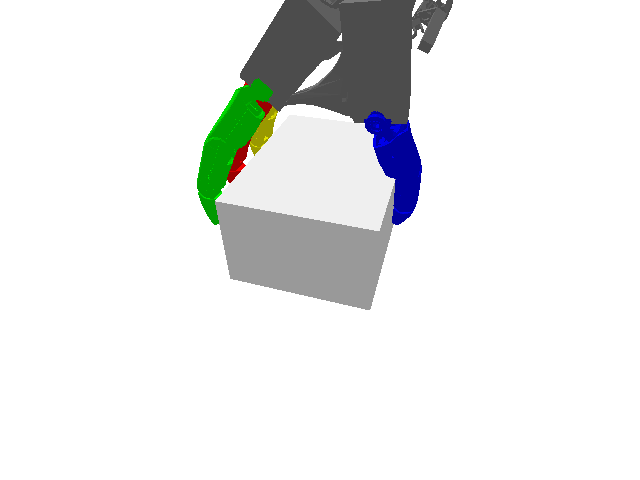

In [88]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Define your real data folder here ──
# not in the split_50, split_10
root = Path("../data/studentGrasping/student_grasps_v1/03761084/7cf2f3a1a3de48fda23949c21eddef76/5")

# not in the split_25, split_10
# root = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
#root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f = root / "mesh.obj"
recording = root / "recording.npz"

assert mesh_f.exists(), f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
print("Using DIRECT mode, client ID:", cid)

p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load your hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),  # update if your urdf is elsewhere
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load object mesh once ──
v = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
c = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
p.createMultiBody(
    baseVisualShapeIndex=v,
    baseCollisionShapeIndex=c,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    physicsClientId=cid,
)

# ── 5) Prepare model & data ──
model = load_model(
    joint_ckpt="../configs/checkpoints/epoch=8-step=15000.ckpt",
    config_path="../configs/checkpoints/config.yaml",
    device="cuda:0",
)
model.eval()

data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

poses7d = grasps[:10, :7]             # hand poses
angles12 = grasps[:10, 7:19]          # joint angles - ground truth, just for comparison
scores_n = scores[:10]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop ──
for i, pose7d in enumerate(poses7d):
    if model.loss_type == "basic":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k_logit":
        angles, logits = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "full":
        angles, logits, scores = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)

    distances = np.linalg.norm(angles - angles12[i], axis=1)  # shape: (K,)
    best_k = np.argmin(distances)

    best_prediction = angles[best_k] 
    print("\n Closest to ground truth prediction: \n",best_prediction)

    max_logit = np.argmax(logits)
    inference_prediction = angles[max_logit]
    print("\n Inference time prediction: \n", inference_prediction)

    print("\n Logits: \n", logits)

    # reset pose & joints
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    for a, j in zip(inference_prediction, [1,2,3,7,8,9,13,14,15,19,20,21]):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in {3,9,15,21}:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # snapshot
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.5,
        yaw=15, pitch=-40, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    w, h, rgba, _, _ = p.getCameraImage(640, 480,
                                        viewMatrix=view,
                                        projectionMatrix=proj,
                                        physicsClientId=cid)
    img = Image.fromarray(rgba[:, :, :3])

    print(f"Grasp {i}:")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)
    time.sleep(0.5)

p.disconnect(physicsClientId=cid)


Using DIRECT mode, client ID: 2

MLP Head Architecture (loss_type: min_k_logit)
Input dimension: 391
Hidden dimensions: [512, 256, 128]
Output dimension: 65

Layer-by-layer breakdown:
--------------------------------------------------

 Closest to ground truth prediction: 
 [ 0.013405 -0.0974    0.3254   -0.2227   -0.03577   0.324    -0.37
 -0.04337   0.3008   -0.288    -0.1897    0.2512  ]

 Inference time prediction: 
 [ 0.38    1.463   1.791   0.1831 -0.1357  0.2825 -0.1193 -0.1595  0.358
 -0.2369 -0.2462  0.2296]

 Logits: 
 [ 0.04565 -0.2598  -1.452    0.1501   0.4626 ]
Grasp 0:
    palm  (xyz, qxqyqzqw) = [-0.028, -0.004, 0.293, 0.009, 0.986, -0.011, 0.167]
    joints (12 angles)  = [[0.3798828125, 1.462890625, 1.791015625, 0.1829833984375, -0.135986328125, 0.281982421875, -0.1190185546875, -0.1600341796875, 0.35791015625, -0.237060546875, -0.2459716796875, 0.22998046875], [0.1419677734375, 0.1419677734375, 0.2099609375, -0.045989990234375, 0.287109375, 0.1629638671875, -0.288085

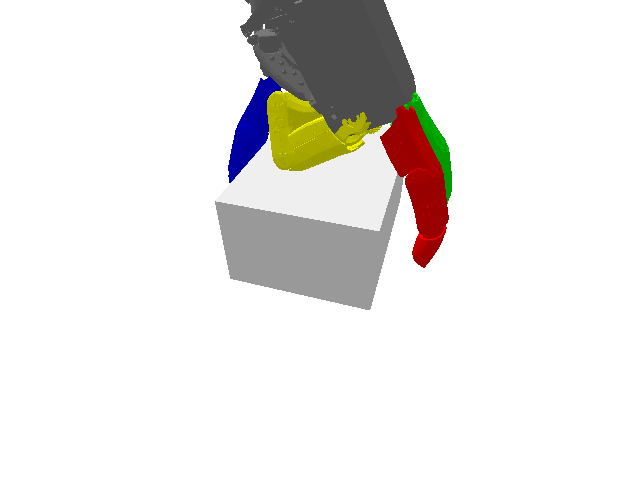


 Closest to ground truth prediction: 
 [ 0.0215  -0.08746  0.3262  -0.2344  -0.01926  0.319   -0.3887  -0.02385
  0.2883  -0.2903  -0.1864   0.2534 ]

 Inference time prediction: 
 [ 0.3904  1.5     1.84    0.1913 -0.1602  0.2747 -0.1377 -0.1606  0.3794
 -0.2451 -0.2288  0.2306]

 Logits: 
 [-0.0459 -0.2896 -1.499   0.202   0.538 ]
Grasp 1:
    palm  (xyz, qxqyqzqw) = [-0.045, -0.011, 0.296, -0.012, 0.986, 0.016, 0.166]
    joints (12 angles)  = [[0.389892578125, 1.5, 1.83984375, 0.1910400390625, -0.1600341796875, 0.27490234375, -0.137939453125, -0.1610107421875, 0.3798828125, -0.2449951171875, -0.22900390625, 0.23095703125], [0.157958984375, 0.1619873046875, 0.2020263671875, -0.045013427734375, 0.322021484375, 0.1500244140625, -0.304931640625, 0.41796875, 0.1629638671875, -0.3369140625, -0.18505859375, 0.218017578125], [0.39697265625, 0.7001953125, 1.1171875, 0.260009765625, -0.1590576171875, 0.450927734375, -0.07098388671875, -0.2230224609375, 0.458984375, -0.320068359375, -0.213012

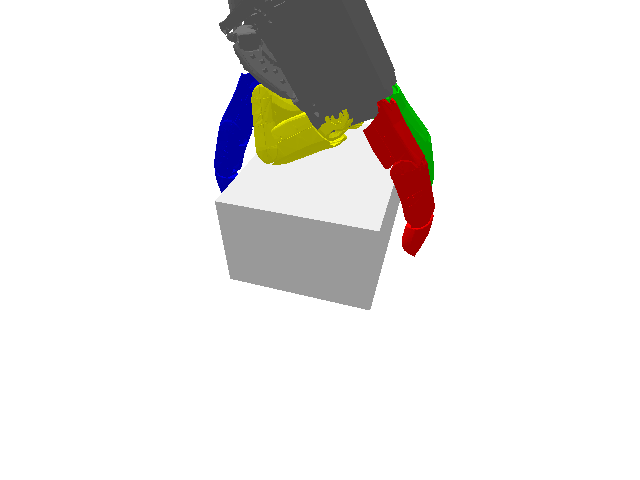


 Closest to ground truth prediction: 
 [ 0.02217 -0.06198  0.3486  -0.1785  -0.0267   0.3638  -0.3218  -0.03287
  0.3467  -0.2983  -0.1855   0.2468 ]

 Inference time prediction: 
 [ 0.1447   0.2085   0.2034  -0.02069  0.3115   0.1769  -0.2379   0.3809
  0.2141  -0.3362  -0.2264   0.2292 ]

 Logits: 
 [-0.258  -0.1733 -1.203   0.1503  0.2146]
Grasp 2:
    palm  (xyz, qxqyqzqw) = [-0.053, 0.005, 0.291, -0.021, 0.976, 0.016, 0.217]
    joints (12 angles)  = [[0.383056640625, 1.458984375, 1.7841796875, 0.175048828125, 0.042999267578125, 0.383056640625, -0.0770263671875, -0.040985107421875, 0.318115234375, -0.22705078125, -0.2249755859375, 0.2159423828125], [0.14501953125, 0.2080078125, 0.2030029296875, -0.02099609375, 0.31201171875, 0.177001953125, -0.238037109375, 0.381103515625, 0.2139892578125, -0.3359375, -0.2259521484375, 0.22900390625], [0.3779296875, 1.0908203125, 1.4697265625, 0.198974609375, -0.133056640625, 0.4189453125, -0.083984375, -0.2110595703125, 0.448974609375, -0.275878

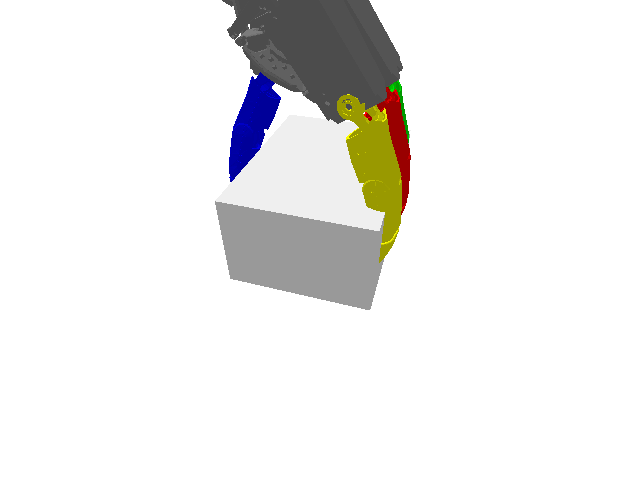


 Closest to ground truth prediction: 
 [ 0.3923  1.504   1.855   0.1993 -0.1196  0.1904 -0.136  -0.0884  0.3352
 -0.2471 -0.1849  0.2101]

 Inference time prediction: 
 [ 0.1675   0.2139   0.183   -0.04004  0.3547   0.13    -0.2964   0.3926
  0.1469  -0.3523  -0.174    0.2108 ]

 Logits: 
 [-0.1956   0.01857 -1.663    0.1732   0.4148 ]
Grasp 3:
    palm  (xyz, qxqyqzqw) = [-0.043, 0.054, 0.288, 0.668, 0.714, -0.069, 0.199]
    joints (12 angles)  = [[0.39208984375, 1.50390625, 1.85546875, 0.198974609375, -0.1199951171875, 0.18994140625, -0.135986328125, -0.0880126953125, 0.3349609375, -0.2469482421875, -0.18505859375, 0.2099609375], [0.16796875, 0.2139892578125, 0.1829833984375, -0.040008544921875, 0.35498046875, 0.1300048828125, -0.2958984375, 0.39208984375, 0.14697265625, -0.35205078125, -0.1739501953125, 0.2110595703125], [0.39697265625, 0.67822265625, 1.033203125, 0.259033203125, -0.08099365234375, 0.424072265625, -0.09002685546875, -0.154052734375, 0.43896484375, -0.34912109375, 

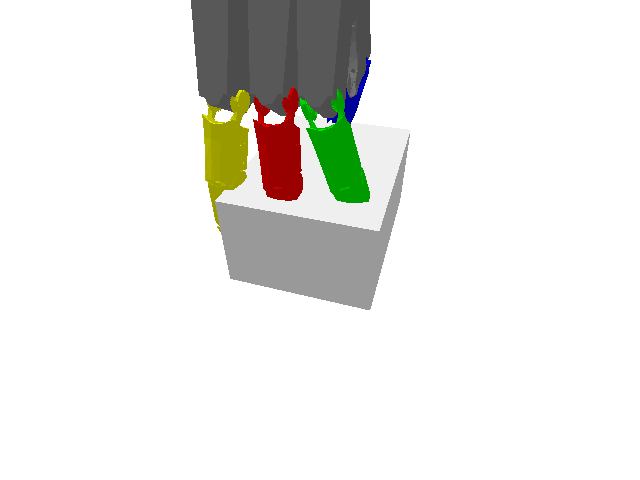


 Closest to ground truth prediction: 
 [ 0.4036  1.538   1.898   0.196  -0.2106  0.1376 -0.1779 -0.1583  0.3245
 -0.2162 -0.1653  0.235 ]

 Inference time prediction: 
 [ 0.148    0.1804   0.1448  -0.09033  0.3335   0.08264 -0.3662   0.363
  0.10535 -0.3293  -0.1423   0.2487 ]

 Logits: 
 [-0.1089  -0.04633 -1.949    0.446    0.4265 ]
Grasp 4:
    palm  (xyz, qxqyqzqw) = [-0.052, 0.006, 0.304, 0.701, 0.702, -0.004, 0.125]
    joints (12 angles)  = [[0.404052734375, 1.5380859375, 1.8984375, 0.196044921875, -0.2110595703125, 0.137939453125, -0.177978515625, -0.157958984375, 0.323974609375, -0.2159423828125, -0.1650390625, 0.2349853515625], [0.14794921875, 0.1800537109375, 0.14501953125, -0.09002685546875, 0.333984375, 0.0830078125, -0.365966796875, 0.363037109375, 0.10498046875, -0.3291015625, -0.1419677734375, 0.2490234375], [0.4208984375, 0.5498046875, 0.9482421875, 0.291015625, -0.1240234375, 0.41796875, -0.10699462890625, -0.1800537109375, 0.4140625, -0.344970703125, -0.211059570312

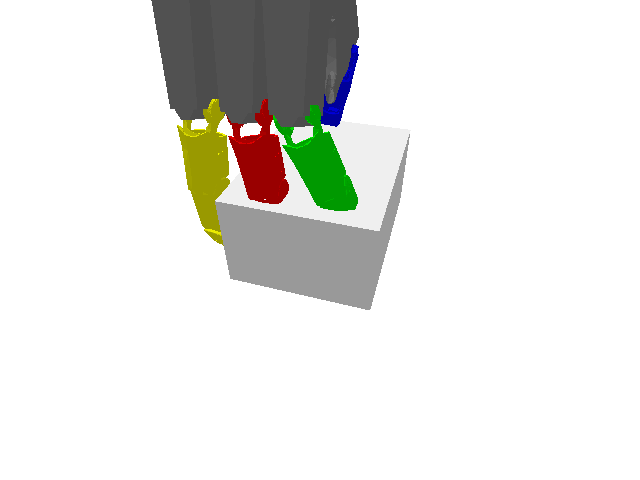


 Closest to ground truth prediction: 
 [ 3.0563e-02 -7.2815e-02  3.2715e-01 -2.3621e-01 -1.0914e-04  3.2227e-01
 -3.9526e-01  3.5210e-03  2.8662e-01 -3.0859e-01 -2.1753e-01  2.5171e-01]

 Inference time prediction: 
 [ 0.3955  1.512   1.861   0.1956 -0.204   0.2551 -0.1366 -0.1713  0.394
 -0.2605 -0.256   0.2362]

 Logits: 
 [-0.04773 -0.2803  -1.613    0.1941   0.591  ]
Grasp 5:
    palm  (xyz, qxqyqzqw) = [-0.014, 0.046, 0.302, 0.709, 0.678, -0.1, 0.167]
    joints (12 angles)  = [[0.39599609375, 1.51171875, 1.861328125, 0.196044921875, -0.2039794921875, 0.2548828125, -0.136962890625, -0.1710205078125, 0.39404296875, -0.260009765625, -0.256103515625, 0.2359619140625], [0.1719970703125, 0.16796875, 0.2039794921875, -0.0360107421875, 0.3330078125, 0.14794921875, -0.30810546875, 0.424072265625, 0.157958984375, -0.343994140625, -0.18994140625, 0.2099609375], [0.402099609375, 0.7060546875, 1.13671875, 0.27392578125, -0.177001953125, 0.4619140625, -0.073974609375, -0.241943359375, 0.46411

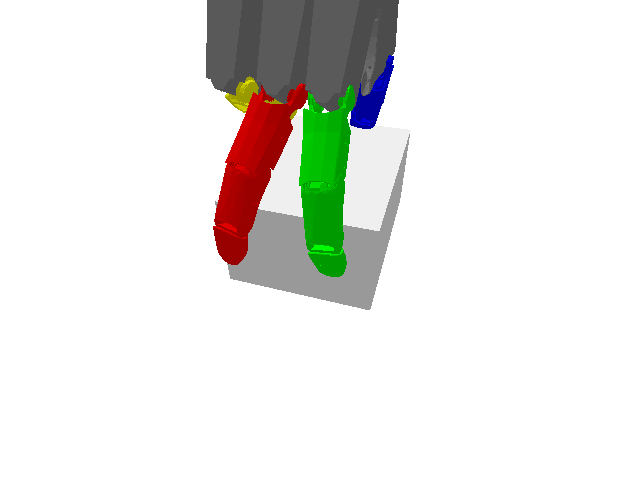


 Closest to ground truth prediction: 
 [ 0.1455  0.1376  0.1805 -0.0792  0.3196  0.1289 -0.3647  0.4329  0.1533
 -0.3384 -0.1642  0.2317]

 Inference time prediction: 
 [ 0.395   1.551   1.903   0.1859 -0.2903  0.2311 -0.1844 -0.2644  0.4138
 -0.2427 -0.2576  0.276 ]

 Logits: 
 [-0.03192 -0.4949  -1.604    0.3823   0.7207 ]
Grasp 6:
    palm  (xyz, qxqyqzqw) = [-0.038, 0.029, 0.29, 0.997, 0.029, -0.02, 0.074]
    joints (12 angles)  = [[0.39501953125, 1.55078125, 1.9033203125, 0.18603515625, -0.2900390625, 0.23095703125, -0.1839599609375, -0.263916015625, 0.4140625, -0.2430419921875, -0.258056640625, 0.27587890625], [0.14599609375, 0.137939453125, 0.1800537109375, -0.0789794921875, 0.320068359375, 0.1290283203125, -0.364990234375, 0.43310546875, 0.1529541015625, -0.337890625, -0.1639404296875, 0.2320556640625], [0.410888671875, 0.43408203125, 0.92578125, 0.298095703125, -0.2060546875, 0.47607421875, -0.073974609375, -0.2449951171875, 0.4619140625, -0.340087890625, -0.2359619140625, 0

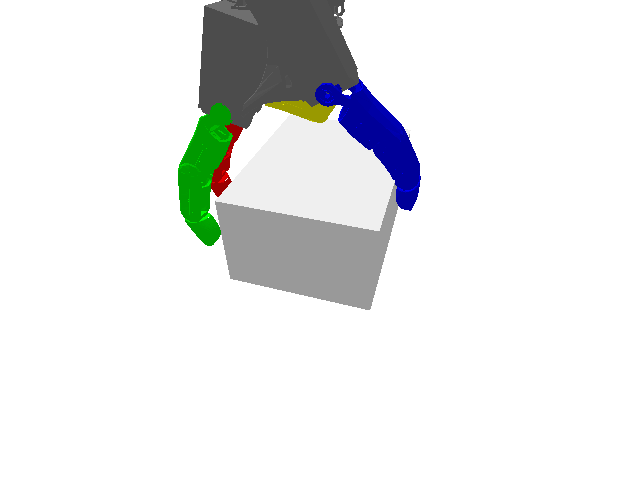


 Closest to ground truth prediction: 
 [ 0.1604    0.1913    0.2239   -0.005817  0.3198    0.1895   -0.2322
  0.4163    0.2207   -0.3518   -0.221     0.1906  ]

 Inference time prediction: 
 [ 0.379    1.475    1.807    0.1813  -0.07416  0.3062  -0.10046 -0.08923
  0.3635  -0.2559  -0.2457   0.2262 ]

 Logits: 
 [-0.04593 -0.2473  -1.28    -0.01987  0.4292 ]
Grasp 7:
    palm  (xyz, qxqyqzqw) = [0.02, 0.07, 0.297, 0.98, 0.019, -0.157, 0.12]
    joints (12 angles)  = [[0.37890625, 1.474609375, 1.806640625, 0.1810302734375, -0.073974609375, 0.305908203125, -0.0999755859375, -0.0889892578125, 0.364013671875, -0.256103515625, -0.2459716796875, 0.2259521484375], [0.1600341796875, 0.1910400390625, 0.2239990234375, -0.006000518798828125, 0.320068359375, 0.18994140625, -0.2320556640625, 0.416015625, 0.220947265625, -0.35205078125, -0.220947265625, 0.18994140625], [0.3798828125, 0.85595703125, 1.25390625, 0.2249755859375, -0.1300048828125, 0.446044921875, -0.0679931640625, -0.2020263671875, 0.

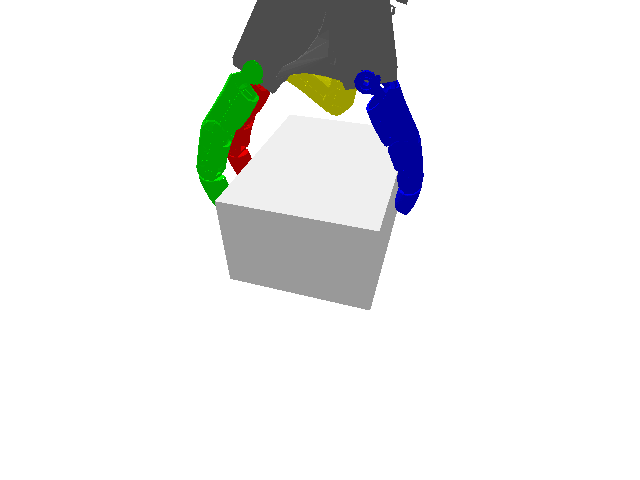


 Closest to ground truth prediction: 
 [ 0.0737   0.01945  0.3198  -0.1946   0.08716  0.3208  -0.3677   0.0846
  0.299   -0.3315  -0.2925   0.2524 ]

 Inference time prediction: 
 [ 0.0737   0.01945  0.3198  -0.1946   0.08716  0.3208  -0.3677   0.0846
  0.299   -0.3315  -0.2925   0.2524 ]

 Logits: 
 [-0.1439 -0.319  -1.096  -0.217   0.6567]
Grasp 8:
    palm  (xyz, qxqyqzqw) = [0.037, 0.081, 0.295, 0.965, 0.04, -0.173, 0.194]
    joints (12 angles)  = [[0.382080078125, 1.521484375, 1.8720703125, 0.197998046875, -0.1390380859375, 0.27587890625, -0.1209716796875, -0.09600830078125, 0.4140625, -0.2958984375, -0.2529296875, 0.2349853515625], [0.197021484375, 0.2110595703125, 0.238037109375, 0.016998291015625, 0.363037109375, 0.2039794921875, -0.23095703125, 0.48193359375, 0.219970703125, -0.365966796875, -0.2249755859375, 0.1689453125], [0.37890625, 0.56591796875, 0.9609375, 0.2509765625, -0.1099853515625, 0.493896484375, -0.048004150390625, -0.1839599609375, 0.51611328125, -0.3549804687

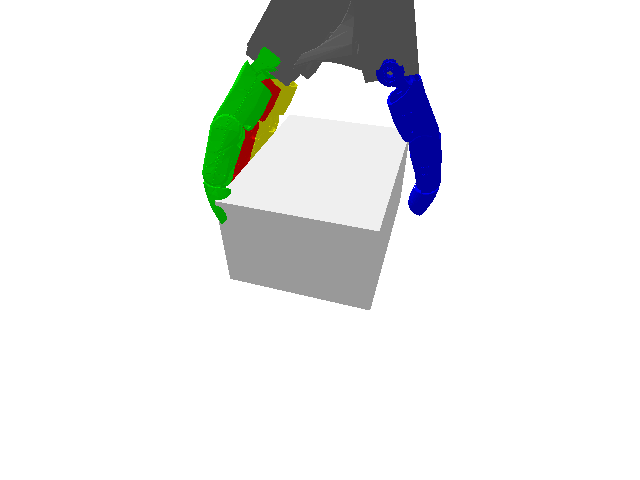


 Closest to ground truth prediction: 
 [ 0.0504   0.02849  0.3074  -0.2063   0.09216  0.3093  -0.3743   0.10583
  0.2766  -0.3345  -0.2172   0.2322 ]

 Inference time prediction: 
 [ 0.1962    0.2444    0.2073    0.005768  0.3835    0.1581   -0.2434
  0.4402    0.1753   -0.363    -0.216     0.1877  ]

 Logits: 
 [-0.1975 -0.0607 -1.436  -0.0215  0.4763]
Grasp 9:
    palm  (xyz, qxqyqzqw) = [0.053, 0.024, 0.287, 0.974, 0.024, -0.225, 0.027]
    joints (12 angles)  = [[0.39697265625, 1.5166015625, 1.873046875, 0.20703125, -0.09600830078125, 0.258056640625, -0.11102294921875, -0.053009033203125, 0.35791015625, -0.27197265625, -0.22998046875, 0.2159423828125], [0.196044921875, 0.2440185546875, 0.20703125, 0.006000518798828125, 0.384033203125, 0.157958984375, -0.2430419921875, 0.43994140625, 0.175048828125, -0.363037109375, -0.2159423828125, 0.18798828125], [0.39404296875, 0.78076171875, 1.1513671875, 0.2509765625, -0.08099365234375, 0.44091796875, -0.072998046875, -0.1600341796875, 0.4528

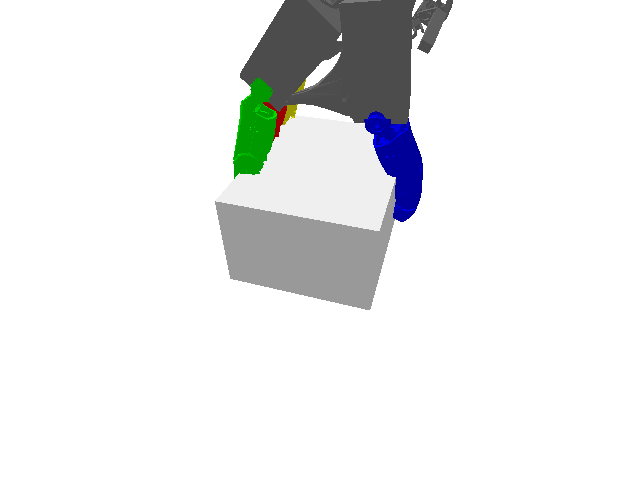

In [ ]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Define your real data folder here ──
# not in the split_50, split_10
root = Path("../data/studentGrasping/student_grasps_v1/03761084/7cf2f3a1a3de48fda23949c21eddef76/5")

# not in the split_25, split_10
# root = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
#root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f = root / "mesh.obj"
recording = root / "recording.npz"

assert mesh_f.exists(), f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
print("Using DIRECT mode, client ID:", cid)

p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load your hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),  # update if your urdf is elsewhere
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load object mesh once ──
v = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
c = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
p.createMultiBody(
    baseVisualShapeIndex=v,
    baseCollisionShapeIndex=c,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    physicsClientId=cid,
)

# ── 5) Prepare model & data ──
model = load_model(
    joint_ckpt="../configs/checkpoints/epoch=8-step=15000.ckpt",
    config_path="../configs/checkpoints/config.yaml",
    device="cuda:0",
)
model.eval()

data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

poses7d = grasps[:10, :7]             # hand poses
angles12 = grasps[:10, 7:19]          # joint angles - ground truth, just for comparison
scores_n = scores[:10]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop ──
for i, pose7d in enumerate(poses7d):
    if model.loss_type == "basic":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k_logit":
        angles, logits = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "full":
        angles, logits, scores = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)

    distances = np.linalg.norm(angles - angles12[i], axis=1)  # shape: (K,)
    best_k = np.argmin(distances)

    best_prediction = angles[best_k] 
    print("\n Closest to ground truth prediction: \n",best_prediction)

    sorted_indices = np.argsort(logits)[::-1]
    second_max_logit = sorted_indices[2]

    inference_prediction = angles[second_max_logit]
    print("\n Inference time prediction: \n", inference_prediction)

    print("\n Logits: \n", logits)

    # reset pose & joints
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    for a, j in zip(inference_prediction, [1,2,3,7,8,9,13,14,15,19,20,21]):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in {3,9,15,21}:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # snapshot
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.5,
        yaw=15, pitch=-40, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    w, h, rgba, _, _ = p.getCameraImage(640, 480,
                                        viewMatrix=view,
                                        projectionMatrix=proj,
                                        physicsClientId=cid)
    img = Image.fromarray(rgba[:, :, :3])

    print(f"Grasp {i}:")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)
    time.sleep(0.5)

p.disconnect(physicsClientId=cid)

### Ground Truth Prediction Visualization

Grasp 0: score = 12.953
    palm  (xyz, qxqyqzqw) = [-0.046, -0.009, 0.27, -0.066, 0.976, 0.004, 0.208]
    joints (12 angles)  = [0.029, 0.761, -0.095, -0.151, 0.891, -0.163, -0.396, 0.801, -0.115, -0.309, 0.471, -0.163]


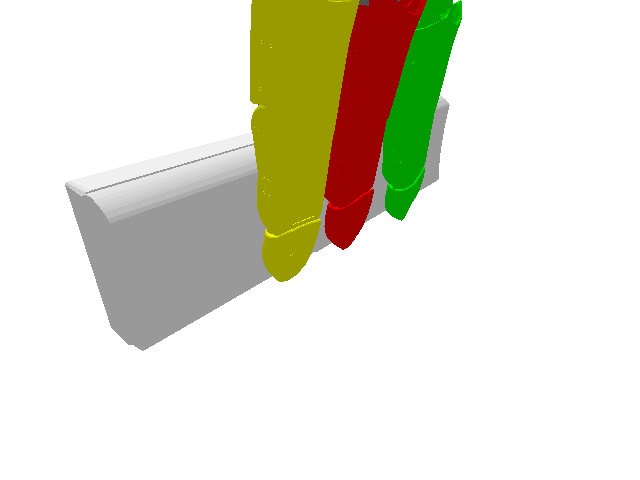

Grasp 1: score = 11.055
    palm  (xyz, qxqyqzqw) = [-0.042, 0.021, 0.277, -0.064, 0.979, -0.056, 0.186]
    joints (12 angles)  = [0.066, 0.741, -0.138, -0.138, 0.831, -0.137, -0.49, 0.791, -0.159, -0.269, 0.501, -0.157]


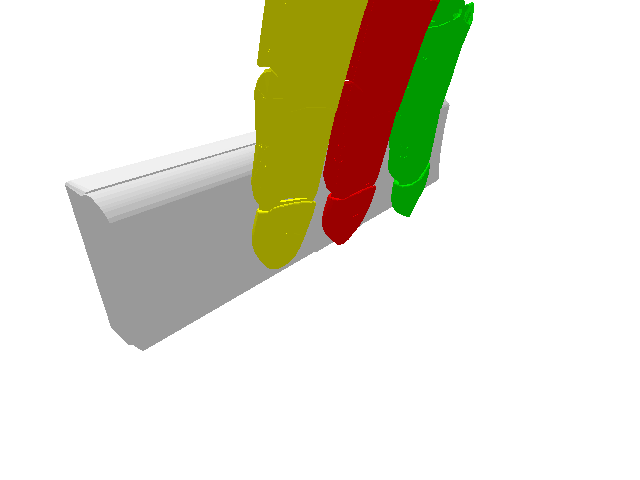

Grasp 2: score = -0.291
    palm  (xyz, qxqyqzqw) = [-0.239, 0.04, 0.143, 0.53, 0.638, 0.172, 0.532]
    joints (12 angles)  = [0.21, 1.501, 1.825, -0.121, -0.069, -0.139, -0.212, 0.031, 0.287, -0.317, 1.501, 1.825]


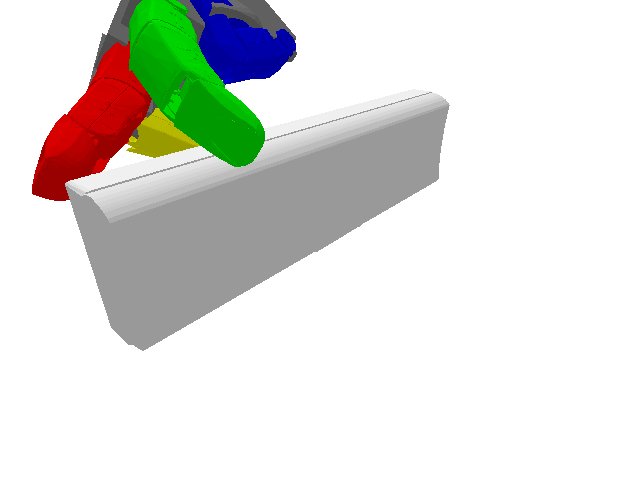

Grasp 3: score = 10.136
    palm  (xyz, qxqyqzqw) = [0.008, -0.006, 0.295, -0.053, 0.998, -0.013, 0.011]
    joints (12 angles)  = [0.01, 0.431, -0.124, -0.216, 0.521, -0.152, -0.518, 0.471, -0.154, -0.106, 0.741, -0.099]


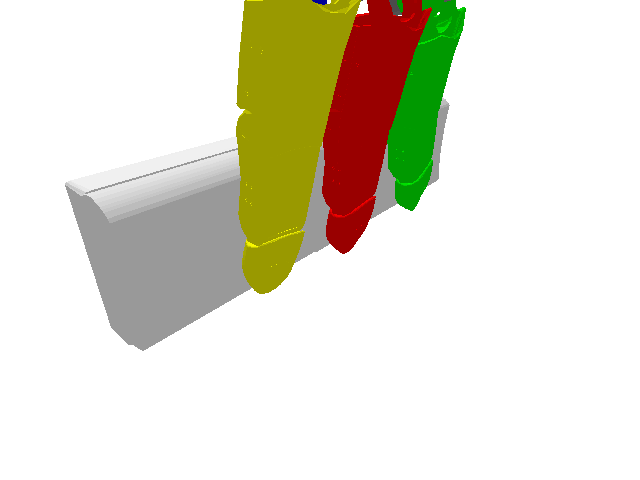

Grasp 4: score = 9.215
    palm  (xyz, qxqyqzqw) = [0.005, -0.008, 0.291, 0.996, 0.063, -0.034, 0.046]
    joints (12 angles)  = [0.496, 0.401, -0.173, 0.283, 0.491, -0.095, -0.428, 0.431, -0.083, -0.351, 0.701, -0.063]


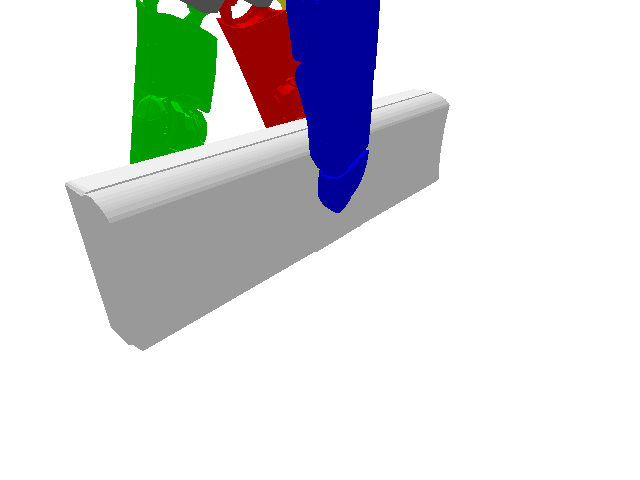

Grasp 5: score = -0.000
    palm  (xyz, qxqyqzqw) = [-0.044, -0.007, 0.29, 0.596, 0.794, 0.004, 0.118]
    joints (12 angles)  = [0.494, 1.501, 1.825, 0.452, 1.501, 1.825, -0.3, 0.841, 0.288, -0.038, -0.349, -0.165]


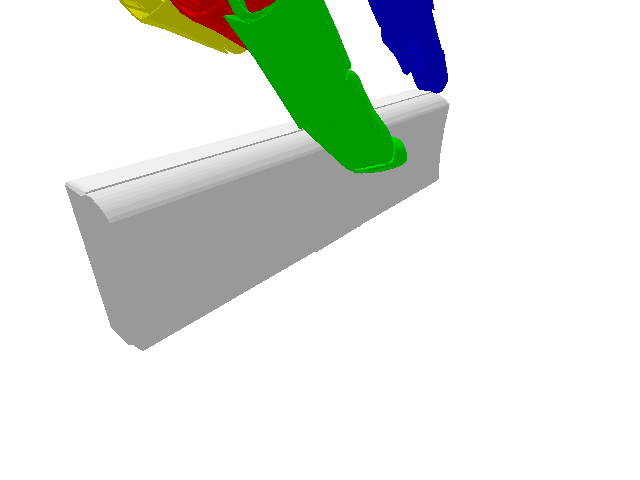

Grasp 6: score = 11.954
    palm  (xyz, qxqyqzqw) = [0.017, 0.034, 0.285, 0.989, 0.038, -0.116, 0.078]
    joints (12 angles)  = [0.049, 0.651, -0.125, -0.152, 0.761, -0.169, -0.318, 0.741, -0.166, -0.3, 0.561, -0.117]


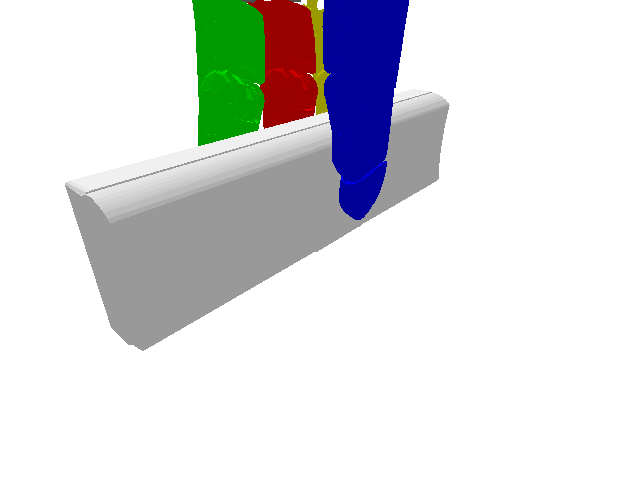

Grasp 7: score = 11.767
    palm  (xyz, qxqyqzqw) = [0.003, 0.047, 0.286, 0.992, 0.042, -0.078, 0.089]
    joints (12 angles)  = [-0.069, 0.631, -0.154, -0.288, 0.711, -0.167, -0.308, 0.681, -0.158, -0.19, 0.591, -0.102]


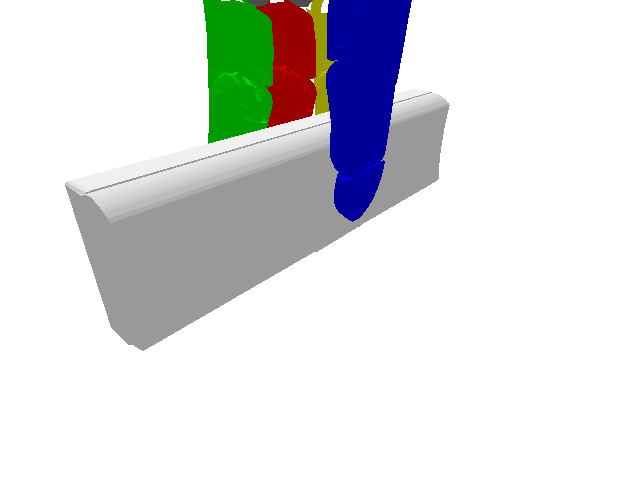

Grasp 8: score = 11.115
    palm  (xyz, qxqyqzqw) = [0.011, 0.084, 0.281, 0.977, 0.034, -0.114, 0.179]
    joints (12 angles)  = [0.018, 0.681, -0.131, -0.12, 0.791, -0.173, -0.363, 0.741, -0.173, -0.253, 0.541, -0.108]


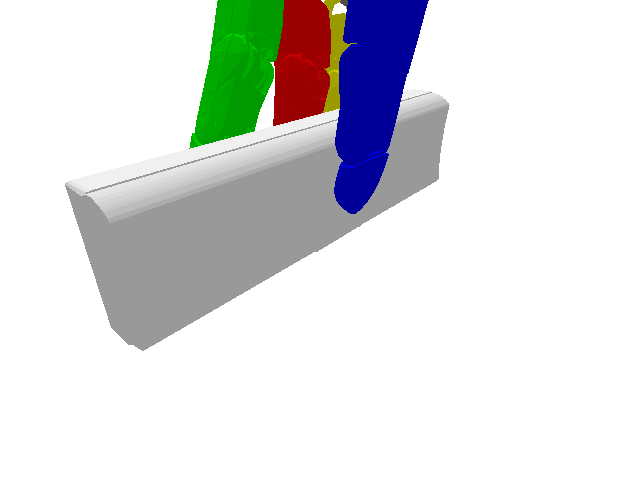

Grasp 9: score = 14.133
    palm  (xyz, qxqyqzqw) = [0.034, 0.018, 0.268, 0.977, 0.076, -0.191, 0.047]
    joints (12 angles)  = [-0.022, 0.841, -0.141, -0.064, 0.921, -0.162, -0.361, 0.841, -0.143, -0.366, 0.431, -0.151]


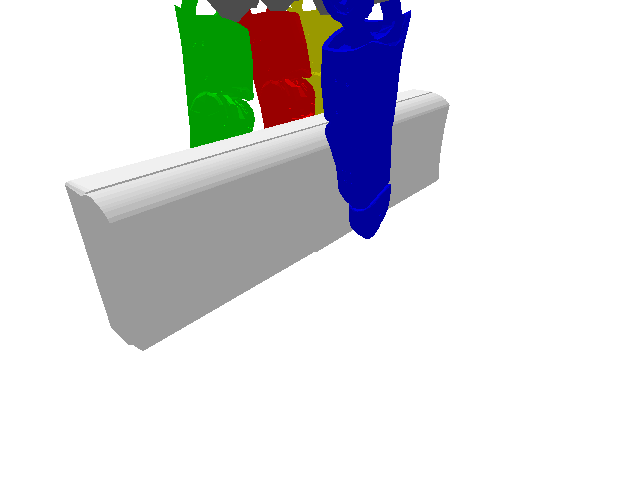

In [ ]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Point to your data folder ──
# not in the split_50
root = Path("../data/studentGrasping/student_grasps_v1/03761084/7cf2f3a1a3de48fda23949c21eddef76/5")

# not in the split_25
# root  = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
# root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f    = root / "mesh.obj"
recording = root / "recording.npz"
assert mesh_f.exists(),    f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load the hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load the object mesh once ──
v = p.createVisualShape(p.GEOM_MESH, fileName=str(mesh_f.resolve()), meshScale=1.0, physicsClientId=cid)
c = p.createCollisionShape(p.GEOM_MESH, fileName=str(mesh_f.resolve()), meshScale=1.0, physicsClientId=cid)
p.createMultiBody(baseVisualShapeIndex=v, baseCollisionShapeIndex=c,
                  basePosition=[0,0,0], baseOrientation=[0,0,0,1],
                  physicsClientId=cid)

# ── 5) Load recorded grasps & scores ──
data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

n        = min(10, grasps.shape[0])  # show up to first 10
poses7d  = grasps[:n, :7]            # palm pose
angles12 = grasps[:n, 7:19]          # joint angles
scores_n = scores[:n]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop with score printout ──
for i, (pose7d, angles, score) in enumerate(zip(poses7d, angles12, scores_n)):
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    # reset all 12 finger joints (and their coupled partners)
    for a, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # grab a quick camera frame
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.5,
        yaw=15, pitch=-40, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    _, _, rgba, _, _ = p.getCameraImage(
        640, 480,
        viewMatrix=view, projectionMatrix=proj,
        physicsClientId=cid
    )
    img = Image.fromarray(rgba[:, :, :3])

    # print score, palm pose, and joint angles
    print(f"Grasp {i}: score = {score:.3f}")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)

    time.sleep(0.5)  # pause so you can visually inspect each grasp

p.disconnect(physicsClientId=cid)


In [ ]:
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",            # your trained regressor
    config_path="../configs/train_joint.yaml",
    #backbone_ckpt="checkpoints/pretrain_pointjepa.ckpt",  # if you want to override backbone first
    device="cuda:0",
)

angles = predict_joint_angles(
    model,
    mesh_path="../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj",
    pose7d=[0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0],
)
print("Predicted joint angles:", angles)


## PyBullet Script

In [ ]:
"""
grasp_vis.py
============

Tiny utility to render a single grasp with the DLR-II hand in PyBullet.

Usage from a script / notebook
------------------------------
model = load_model(...)

pose7d  = [0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0]          # xyz + quaternion
mesh    = "../data/grasp_sample/02818832/.../mesh.obj"

predict_and_visualize(model, mesh, pose7d, hand_urdf="urdfs/dlr2.urdf")
"""

from pathlib import Path
import numpy as np
import pybullet as p
import pybullet_data
import argparse
from typing import Sequence

# order expected by the DLR-II URDF (same as the supervisor’s script)
_HAND_JOINT_INDICES = [1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21]
_COUPLED_JOINTS     = {3, 9, 15, 21}        # They also drive j+1

def _ensure_connection(gui: bool = True) -> int:
    """Connect to PyBullet once and return the client id."""
    if p.isConnected():
        return p.getConnectionInfo()['clientIndex']
    connection_mode = p.GUI if gui else p.DIRECT
    return p.connect(connection_mode)


def visualize_grasp(
        mesh_path: str | Path,
        pose7d: Sequence[float],
        joint_angles: Sequence[float],
        *,
        hand_urdf: str = "urdfs/dlr2.urdf",
        object_mass: float = 1.0,
        mesh_scale: float | Sequence[float] = 1.0,
        wait_for_input: bool = True,
) -> None:
    """
    Show a single grasp in PyBullet.

    Parameters
    ----------
    mesh_path        : path to the object mesh (.obj)
    pose7d           : (x, y, z, qx, qy, qz, qw) world-space hand base pose
    joint_angles     : iterable of 12 angles in radians (DLR-II finger order)
    hand_urdf        : path to hand URDF
    object_mass      : mass (kg) given to the visual/collision mesh
    mesh_scale       : uniform or xyz scale factor for the mesh
    wait_for_input   : if True, waits for <Enter> before exiting
    """
    if len(pose7d) != 7:
        raise ValueError("pose7d must have 7 elements (xyz + quaternion)")
    if len(joint_angles) != 12:
        raise ValueError("joint_angles must have 12 elements")

    _ensure_connection(gui=True)
    p.resetSimulation()                              # fresh scene
    p.setAdditionalSearchPath(pybullet_data.getDataPath())

    # ------------------------------------------------------------------ hand
    hand_id = p.loadURDF(
        hand_urdf,
        globalScaling=1,
        basePosition=pose7d[:3],
        baseOrientation=pose7d[3:],
        useFixedBase=True,
        flags=p.URDF_MAINTAIN_LINK_ORDER,
    )

    # ----------------------------------------------------------------- object
    mesh_path = Path(mesh_path)
    vshape = p.createVisualShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
        rgbaColor=[1, 1, 1, 1],
        specularColor=[.4, .4, .4],
        visualFramePosition=[0, 0, 0],
    )
    cshape = p.createCollisionShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
    )
    obj_id = p.createMultiBody(
        baseMass=object_mass,
        baseVisualShapeIndex=vshape,
        baseCollisionShapeIndex=cshape,
        basePosition=[0, 0, 0],
        baseOrientation=[0, 0, 0, 1],
    )

    # ---------------------------------------------------------- joint angles
    for angle, j in zip(joint_angles, _HAND_JOINT_INDICES):
        p.resetJointState(hand_id, jointIndex=j, targetValue=angle)
        if j in _COUPLED_JOINTS:                     # drive the coupled joint
            p.resetJointState(hand_id, jointIndex=j + 1, targetValue=angle)

    p.stepSimulation()

    if wait_for_input:
        print("Press <Enter> in the console to close the preview …")
        try:
            input()
        except (EOFError, KeyboardInterrupt):
            pass
    p.disconnect()

In [ ]:
import numpy as np
from pathlib import Path

root     = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record   = root / "recording.npz"
mesh_obj = root / "mesh.obj"

# Correctly load the .npz
data    = np.load(record, allow_pickle=False)   # recording.npz is pure numpy arrays
grasps  = data["grasps"]                        # shape: (24,19)
scores  = data["scores"]                        # shape: (24,)

# Extract the first 7 cols (pose7d) of your first 3 grasps
pose7ds = grasps[:3, :7]                        # (3,7)
print("Loaded poses:", pose7ds.shape, "mesh path:", mesh_obj)

In [ ]:

# (re)load your model if you haven’t already
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

for i, pose7d in enumerate(pose7ds):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    print(f"Grasp #{i}: pose={pose7d}, predicted angles={angles}")
    visualize_grasp(
        mesh_path=mesh_obj,
        pose7d=pose7d,
        joint_angles=angles,
        hand_urdf="urdfs/dlr2.urdf",
        wait_for_input=False,   # in notebooks you often don’t want to block
    )


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# ── your predictor/model imports ──
# ───────────────────────────────────

# constants for the DLR-II hand (same as before)
JOINT_INDICES  = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3, 9, 15, 21}

# 1) connect and load once
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# 2) load hand URDF (fixed base)
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    globalScaling=1,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# 3) load object mesh once
root     = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_obj = str(root / "mesh.obj")
vshape = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
    rgbaColor=[1,1,1,1],
)
cshape = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
)
obj_id = p.createMultiBody(
    baseMass=1,
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# 4) load your model
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

# 5) grab the first 3 poses
data    = np.load(root / "recording.npz")
poses7d = data["grasps"][:3, :7]   # shape (3,7)

# 6) loop and just RESET, no reload
for i, pose7d in enumerate(poses7d):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:])
    # reset the 12 finger joints
    for angle, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, angle)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, angle)
    
    p.stepSimulation()
    print(f"Showing grasp #{i} — press Ctrl+C in console or close window to stop")
    time.sleep(1.0)    # display each grasp for one second

# when done, disconnect
p.disconnect()


In [ ]:
import time
import numpy as np
from pathlib import Path

root    = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record  = np.load(root / "recording.npz")
poses7d = record["grasps"][:3, :7]

model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()                                                  # ensure eval mode

infer_times = []
for pose in poses7d:
    t0 = time.time()
    with torch.no_grad():                                     # avoid autograd
        angles = predict_joint_angles(model,
                                       mesh_path=str(root/"mesh.obj"),
                                       pose7d=pose)
    infer_times.append(time.time() - t0)
print("Per-grasp inference times:", [f"{t:.3f}s" for t in infer_times])


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# hand joint indices
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED      = {3,9,15,21}

# ── Connect & scene setup ──
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# load the hand once
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# load the object mesh once
root   = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_f = str(root / "mesh.obj")
vshape = p.createVisualShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
cshape = p.createCollisionShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
p.createMultiBody(
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# load model once
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

# load poses
data    = np.load(root / "recording.npz", allow_pickle=False)
poses7d = data["grasps"][:3, :7]   # pick first 3
print("Setup done—ready to roll.")


In [ ]:
import pybullet as p
import pybullet_data
from pathlib import Path

# 1) Connect and verify
cid = p.connect(p.GUI)
print("Physics client ID:", cid)
print("Is connected?", p.isConnected(cid))
if cid < 0 or not p.isConnected(cid):
    raise RuntimeError("Failed to open PyBullet GUI")

# 2) Add search paths
#    - the built-in pybullet_data (ground plane, etc.)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#    - plus your project root so that "urdfs/dlr2.urdf" can be found
project_root = Path.cwd()  # or wherever your repo root is
p.setAdditionalSearchPath(str(project_root))

# 3) Reset simulation on that client
p.resetSimulation(physicsClientId=cid)

# 4) Try loading your URDF, explicitly on that client
hand_urdf = str(project_root / "urdfs" / "dlr2.urdf")
hand_id = p.loadURDF(
    hand_urdf,
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)
print("Loaded hand body ID:", hand_id)


## Helper: Checkpoint Inspector

In [ ]:
def inspect_checkpoint(
    ckpt_path: str,
    prefix_filter: str | None = None
) -> None:
    """
    Print all parameter keys saved in a checkpoint. Optionally filter by prefix.

    Args:
        ckpt_path: path to the .ckpt or .pth file
        prefix_filter: only show keys containing this substring
    """
    # Load checkpoint on CPU
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state = ckpt.get('state_dict', ckpt)
    keys = list(state.keys())

    if prefix_filter:
        keys = [k for k in keys if prefix_filter in k]

    print(f"Found {len(keys)} parameters{' with filter ' + prefix_filter if prefix_filter else ''}:")
    for k in sorted(keys):
        print(k)

In [ ]:
inspect_checkpoint("../configs/checkpoints/jepa_no_FT.ckpt")
